In [48]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from IPython.display import display, Image
import ipywidgets as widgets
import threading
import mediapipe as mp

### THRESHOLD
This variable can be adjusted depending on its use. For example, if you want to detect if the person is writing, you'd probably need a threshold lower than if you want to detect if the person is moving its hand abruptly.

#### Using the mean value as threshold
One way to find a good threshold value is by the mean of all movement distances. You'll see at the end how it's done!

### CONFIDENCES
Both min detection and tracking can be adjusted depending on the camera distance as well as other factors such as cam quality. In this case 0.5 is good enough.

In [49]:
threshold = 0.012

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5)

I0000 00:00:1722698135.456424   85807 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1722698135.555448   87967 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.01), renderer: NVIDIA GeForce GTX 1060 3GB/PCIe/SSE2
W0000 00:00:1722698135.576757   87965 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1722698135.603544   87966 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [50]:
total_frames = 0
movs_frames = 0 # Frames where movement was detected
last_hand_landmarks = [None, None]
movement_distances = [] # This variable will be used to plot frames and the distance in that frame if a movement is detected.

In [51]:
video_path = "./video.mp4" # if you want a LIVE test, comment this line and uncomment the line below
# video_path = 0

stopButton = widgets.ToggleButton(
    value=False,
    description='Stop',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='square'
)

def view(button):
    global total_frames, movs_frames, last_hand_landmarks, threshold, movement_distances
    cap = cv2.VideoCapture(video_path)
    display_handle=display(None, display_id=True)
    while True:
        ret, frame = cap.read()
        if ret is None or frame is None:
            break
        total_frames += 1
        fliped_image = cv2.cvtColor(cv2.flip(frame, 1), cv2.COLOR_RGB2BGR)
        results = hands.process(fliped_image)
        image = cv2.cvtColor(fliped_image, cv2.COLOR_RGB2BGR)

        if results.multi_hand_landmarks:
            for i, hand_landmark in enumerate(results.multi_hand_landmarks[:2]):
                mp_drawing.draw_landmarks(image, hand_landmark, mp_hands.HAND_CONNECTIONS)
                if last_hand_landmarks[i] is not None:
                    movement_distance = cv2.norm(
                        hand_landmark.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].x - last_hand_landmarks[i].landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].x,
                        hand_landmark.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y - last_hand_landmarks[i].landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y
                    )
                    if movement_distance > threshold:
                        movs_frames += 1
                        movement_distances.append([total_frames, movement_distance])
                        print(f"MOVEMENT DETECTED IN FRAME #{total_frames} | MOVEMENT DISTANCE: {movement_distance}")
                last_hand_landmarks[i] = hand_landmark
        
        _, buffer = cv2.imencode('.jpeg', image)
        display_handle.update(Image(data=buffer.tobytes()))

        if stopButton.value == True:
            cap.release()
            display_handle.update(None)

ToggleButton(value=False, button_style='danger', description='Stop', icon='square', tooltip='Description')

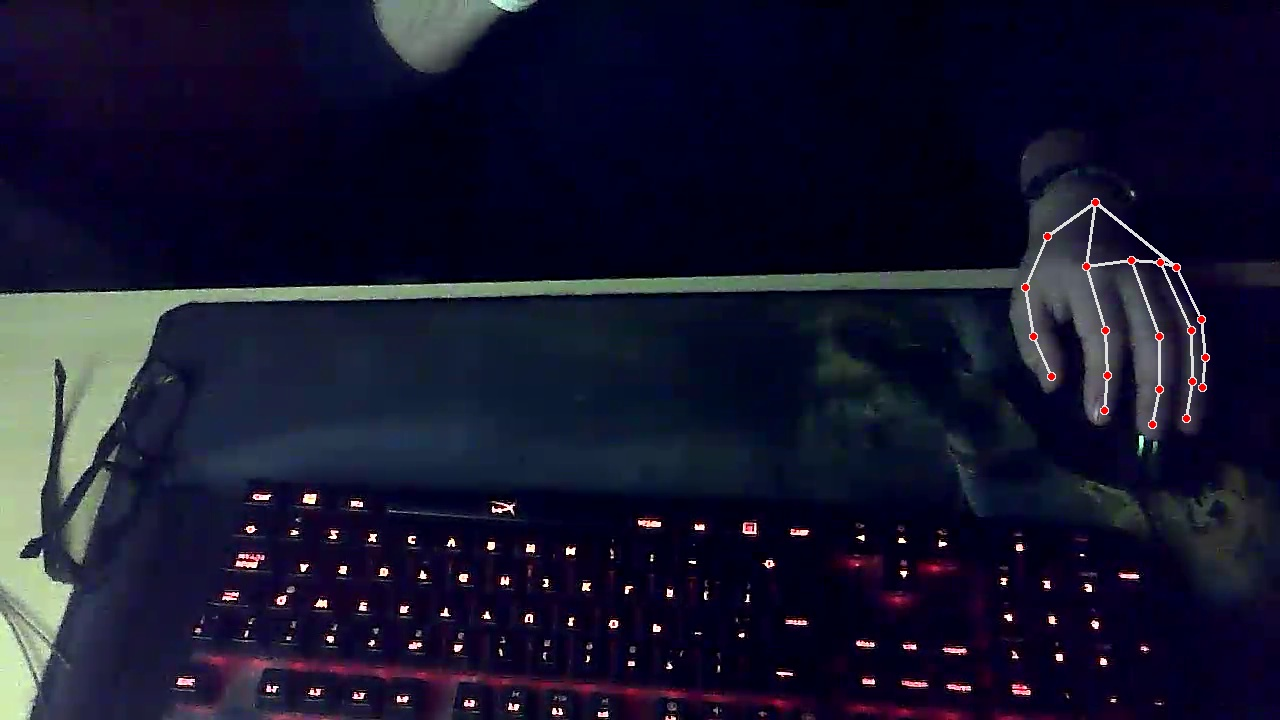

MOVEMENT DETECTED IN FRAME #6 | MOVEMENT DISTANCE: 0.01543724536895752
MOVEMENT DETECTED IN FRAME #10 | MOVEMENT DISTANCE: 0.028378725051879883
MOVEMENT DETECTED IN FRAME #11 | MOVEMENT DISTANCE: 0.035067081451416016
MOVEMENT DETECTED IN FRAME #12 | MOVEMENT DISTANCE: 0.025989890098571777
MOVEMENT DETECTED IN FRAME #13 | MOVEMENT DISTANCE: 0.03673309087753296
MOVEMENT DETECTED IN FRAME #14 | MOVEMENT DISTANCE: 0.02635437250137329
MOVEMENT DETECTED IN FRAME #15 | MOVEMENT DISTANCE: 0.03543651103973389
MOVEMENT DETECTED IN FRAME #16 | MOVEMENT DISTANCE: 0.05904221534729004
MOVEMENT DETECTED IN FRAME #17 | MOVEMENT DISTANCE: 0.06874048709869385
MOVEMENT DETECTED IN FRAME #18 | MOVEMENT DISTANCE: 0.036192119121551514
MOVEMENT DETECTED IN FRAME #19 | MOVEMENT DISTANCE: 0.04202401638031006
MOVEMENT DETECTED IN FRAME #20 | MOVEMENT DISTANCE: 0.026770174503326416
MOVEMENT DETECTED IN FRAME #21 | MOVEMENT DISTANCE: 0.034870445728302
MOVEMENT DETECTED IN FRAME #22 | MOVEMENT DISTANCE: 0.02843254

In [52]:
display(stopButton)
thread = threading.Thread(target=view, args=(stopButton,))
thread.start()

### Movement Distance per Frame
Having the frames where hand movements were found and the distance between two consecutive frames, they can be converted as a numpy array of two dimensions

#### Threshold
As you can see in the following block of code and its respective image, the mean value is close to '0.05'. There are more abrupt movements at the end of the video, those can generate noise when mean is calculated. But for this example, '0.012' is a good threshold, as we saw in the previous video and how the movements were detected.

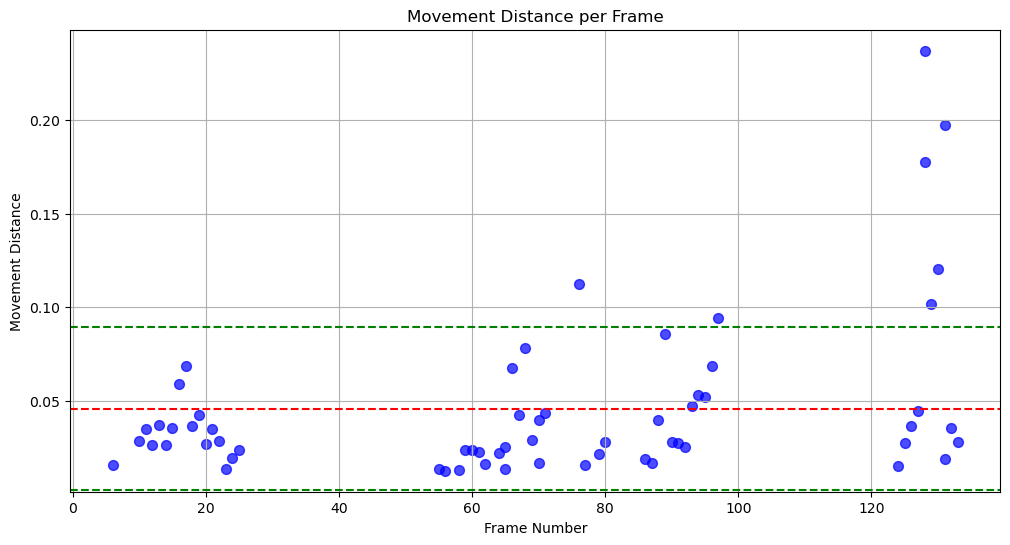

In [53]:
# Create a numpy array of two dimensions
frame_distances = np.array(movement_distances)

frame_numbers = frame_distances[:, 0]
distances = frame_distances[:, 1]

mean_distance = np.mean(distances)
std = np.std(distances)

# Plot the values stored in the np array 'frame_distances'
plt.figure(figsize=(12, 6))
plt.scatter(frame_numbers, distances, color='blue', alpha=0.7, s=50)
plt.axhline(mean_distance, color='red', linestyle='--', label=f'Mean: {mean_distance:.4f}')
plt.axhline(mean_distance + std, color='green', linestyle='--', label=f'Mean + 1 std: {mean_distance + std:.4f}')
plt.axhline(mean_distance - std, color='green', linestyle='--', label=f'Mean - 1 std: {mean_distance - std:.4f}')
plt.xlabel('Frame Number')
plt.ylabel('Movement Distance')
plt.title('Movement Distance per Frame')
plt.grid(True)
plt.show()